In [10]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt

from lib.model import FNO1d
from lib.dataset import PDEDataset
from lib.utils import relative_l2_error

In [11]:
torch.manual_seed(0)
np.random.seed(0)

In [12]:
BATCH_SIZE = 32
DEVICE = "mps"

In [13]:
dataset_train = (
    PDEDataset("data/train_allen_cahn_fourier.npy", device=DEVICE)
    + PDEDataset("data/train_allen_cahn_gmm.npy", device=DEVICE)
    + PDEDataset("data/train_allen_cahn_piecewise.npy", device=DEVICE)
)

In [14]:
training_data, validation_data = torch.utils.data.random_split(
    dataset_train, [int(0.8 * len(dataset_train)), int(0.2 * len(dataset_train))]
)

In [15]:

train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
learning_rate = 0.001
epochs = 50
step_size = 5
gamma = 0.5

In [17]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(DEVICE)  # model

In [18]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [19]:
def loss_f(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return relative_l2_error(output, target)

In [20]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

In [21]:
progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    fno.train()
    train_loss = 0.0
    for i, (dt, input, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        prediction = fno(input, dt).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)
    scheduler.step()

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())

    # Compute validation loss
    with torch.no_grad():
        fno.eval()
        validation_relative_l2 = 0.0
        for i, (dt, input, target) in enumerate(val_data_loader):
            prediction = fno(input, dt).squeeze(-1)

            loss = relative_l2_error(prediction, target)
            validation_relative_l2 += loss.item()

        validation_relative_l2 /= len(val_data_loader)
        metrics["validation_loss"].append(validation_relative_l2)

    # Update progress bar
    progress_bar.set_postfix(
        {"train_loss": train_loss, "val_loss": validation_relative_l2}
    )

100%|██████████| 50/50 [14:45<00:00, 17.71s/it, train_loss=0.0998, val_loss=0.0955]


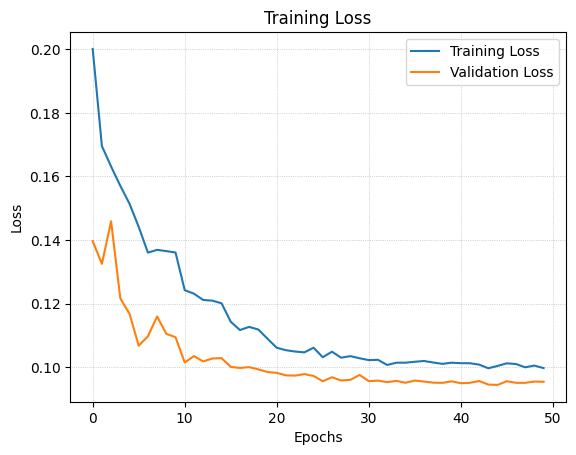

In [22]:
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
# plt.plot(learning_rates, label="Learning Rate")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [23]:
dataset_test = (
    PDEDataset("data/test_allen_cahn_fourier.npy", device=DEVICE)
    + PDEDataset("data/test_allen_cahn_gmm.npy", device=DEVICE)
    + PDEDataset("data/test_allen_cahn_piecewise.npy", device=DEVICE)
)
test_data_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error: {test_relative_l2}")

100%|██████████| 141/141 [00:04<00:00, 31.15it/s]

Test relative L2 error: 0.10632430460858852


In [25]:
# save model to disk
torch.save(fno.state_dict(), "models/tfno_model.pth")